# `nb08`: Automatic Differentiation Variational inference

In [55]:
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import jax.scipy as jsc

from tqdm import tqdm

np.random.seed(777)

# Throwing example from `nb01`

In [56]:
# Gaussian mean-field variational parameterization
def vp_init(size):
    mu = np.random.randn(size)
    log_s = np.random.randn(size)  # omega
    return jnp.array([mu, log_s])

def eps_rvs(size, n=1):
    return np.random.randn(n, size)

def zeta(vp, eps):
    mu = vp[0]
    s = jnp.exp(vp[1])
    return mu + s * eps   

def entropy_q(vp):
    K = len(vp[0])
    return K / 2. * (1. + np.log(2 * np.pi)) + jnp.sum(vp[1]) 

In [57]:
# Transformation from bounded to real
def sigmoid(x):
    return 1. / (1. + jnp.exp(-x))
    
def T(z, a, b):
    zeta = jsc.special.logit((z - a) / (b - a))
    return zeta

def T_inv(zeta, a, b):
    z = a + (b - a) * sigmoid(zeta)
    return z
    
def det_jac_T_inv(zeta, a, b):
    return (b - a) * sigmoid(zeta) * (1 - sigmoid(zeta))

In [58]:
# Prior
def log_prior_v(v):
    return jnp.log(1. / 10)

def log_prior_alpha(alpha):
    return jnp.log(2. / np.pi)

In [59]:
# Likelihood
def _trajectory(v, alpha, dt=0.1, G=9.81):
    v_x = v * jnp.cos(alpha)  # x velocity m/s
    v_y = v * jnp.sin(alpha)  # y velocity m/s
    
    x = 0.0  # initial position
    y = 1.5  # initial height

    while y > 0:  # simulate until ball hits floor
        v_y += dt * -G  # acceleration due to gravity
        x += dt * v_x
        y += dt * v_y
        
    return x, y

def log_likelihood(x_obs, v, alpha, scale=0.5):
    mu, _ = _trajectory(v, alpha)
    return jsc.stats.norm.logpdf(x_obs, loc=mu, scale=scale)

In [60]:
def elbo(vp, x_obs, eps):
    _zeta = zeta(vp, eps)
    out = 0.0
    
    # log p(v)
    v = T_inv(_zeta[0], 0., 10.)
    out += log_prior_v(v)
    out += jnp.log(det_jac_T_inv(_zeta[0], 0., 10.))
    
    # log p(alpha)
    alpha = T_inv(_zeta[1], 0., np.pi / 2)
    out += log_prior_alpha(alpha)
    out += jnp.log(det_jac_T_inv(_zeta[1], 0., np.pi / 2.))
    
    # log p(x|v, alpha)
    out += log_likelihood(x_obs, v, alpha)
    
    # entropy q
    out += entropy_q(vp)
    
    return jnp.sum(out) 

grad_elbo = jax.grad(elbo)

In [61]:
v_true = 5.0
alpha_true = np.pi / 4
mu, _ = _trajectory(v_true, alpha_true)
x_obs = mu + 0.5 * np.random.randn()

vp = vp_init(2)
batchsize = 25
lr = 0.02
n_epochs = 50

In [62]:
test = eps_rvs(2, 100)
g = grad_elbo(vp, x_obs, test[0])

for epoch in range(n_epochs):
    # Log
    elbo_test = np.mean([elbo(vp, x_obs, eps) for eps in test])
    print(f"Epoch {epoch+1}/{n_epochs} - ELBO: {elbo_test:.2f}")
    
    # Update            
    g = jnp.zeros_like(g)
    
    for eps in eps_rvs(2, batchsize):
        g += grad_elbo(vp, x_obs, eps)
    
    vp += lr * g / batchsize

Epoch 1/50 - ELBO: -9.89
Epoch 2/50 - ELBO: -8.85
Epoch 3/50 - ELBO: -7.83
Epoch 4/50 - ELBO: -7.03
Epoch 5/50 - ELBO: -6.16
Epoch 6/50 - ELBO: -5.40
Epoch 7/50 - ELBO: -5.09
Epoch 8/50 - ELBO: -4.80
Epoch 9/50 - ELBO: -4.34
Epoch 10/50 - ELBO: -4.19
Epoch 11/50 - ELBO: -4.03
Epoch 12/50 - ELBO: -3.84
Epoch 13/50 - ELBO: -3.67
Epoch 14/50 - ELBO: -3.58
Epoch 15/50 - ELBO: -3.54
Epoch 16/50 - ELBO: -3.50
Epoch 17/50 - ELBO: -3.48
Epoch 18/50 - ELBO: -3.44
Epoch 19/50 - ELBO: -3.42
Epoch 20/50 - ELBO: -3.38
Epoch 21/50 - ELBO: -3.38
Epoch 22/50 - ELBO: -3.32
Epoch 23/50 - ELBO: -3.31
Epoch 24/50 - ELBO: -3.22
Epoch 25/50 - ELBO: -3.23
Epoch 26/50 - ELBO: -3.22
Epoch 27/50 - ELBO: -3.19
Epoch 28/50 - ELBO: -3.21
Epoch 29/50 - ELBO: -3.21
Epoch 30/50 - ELBO: -3.22
Epoch 31/50 - ELBO: -3.21
Epoch 32/50 - ELBO: -3.23
Epoch 33/50 - ELBO: -3.25
Epoch 34/50 - ELBO: -3.28
Epoch 35/50 - ELBO: -3.20
Epoch 36/50 - ELBO: -3.21
Epoch 37/50 - ELBO: -3.21
Epoch 38/50 - ELBO: -3.24
Epoch 39/50 - ELBO: -

In [63]:
_zeta = zeta(vp, eps_rvs(2, 10000))
v = T_inv(_zeta[:, 0], 0., 10.)
alpha = T_inv(_zeta[:, 1], 0., np.pi / 2.)

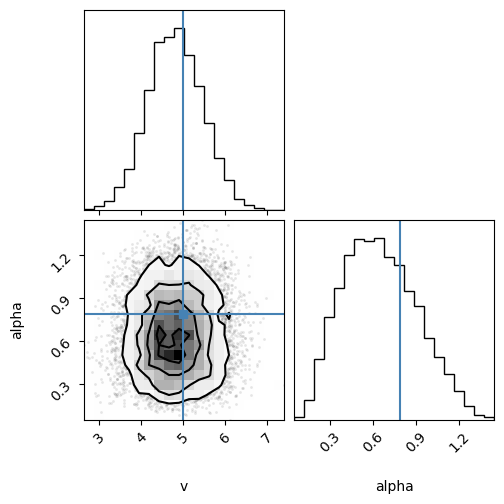

In [64]:
import corner
thetas = np.array([v, alpha]).T
labels = ["v", "alpha"]
fig = corner.corner(thetas, labels=labels, truths=[v_true, alpha_true])

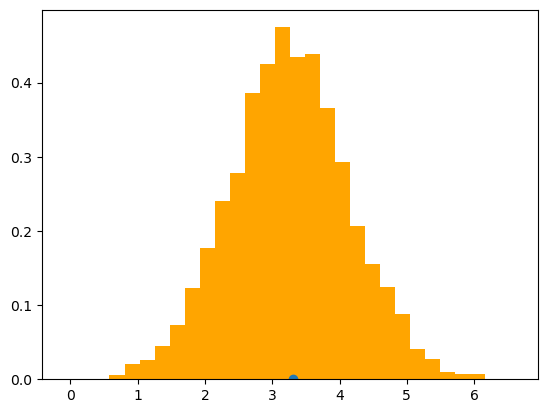

In [65]:
# p(x | x_obs)
xs = []
    
for v, alpha in thetas[:5000]:
    mu, _ = _trajectory(v, alpha)   
    x = np.random.randn(1) * 0.5 + mu
    xs.append(x[0])

plt.hist(xs, density=True, bins=30, color="orange")
plt.scatter([x_obs], [0.])
plt.show()